In [50]:
import sys
import os

import model.build_model
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
from utils import utils

%load_ext autoreload
%autoreload 2
from shash.shash_torch import Shash
import model
from model.build_model import TorchModel
from databuilder import data_loader

imp.reload(model)
imp.reload(model.build_model)

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.26.4
xarray version = 2024.2.0
pytorch version = 2.1.2.post2


In [51]:
config = utils.get_config("exp006")
device = utils.prepare_device(config["device"])

front_cutoff = config["databuilder"]["front_cutoff"] 
back_cutoff = config["databuilder"]["back_cutoff"]

testset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_test.pkl", front_cutoff, back_cutoff)

torch.backends.mps is available
tensor([1.], device='mps:0')
X1 shape: (60058, 3)
Target shape: (60058,)


loading model
loading model RERUN
predicting v5
predicting RERUN
Shash distribution calculations
shape of probability distribution RERUN: (250, 60058)
shape of probability distribution V5: (250, 60058)
plotting


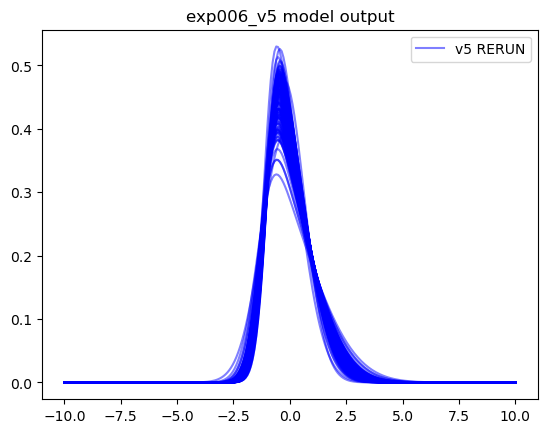

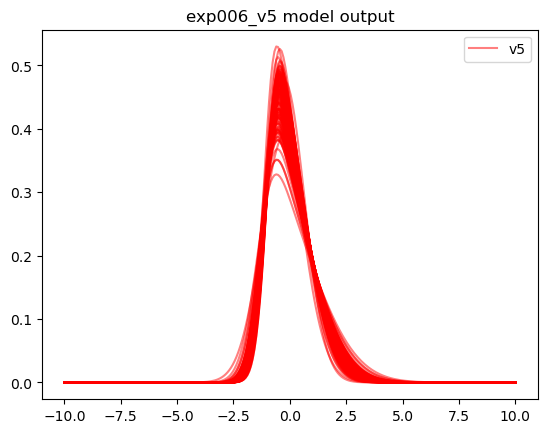

In [56]:
imp.reload(model)
imp.reload(model.build_model)

# open v5 model: 
print("loading model")
path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_v5.pth'
model_v5 = TorchModel(config=config["arch"])
model_v5.load_state_dict(torch.load(path))
model_v5.eval()

print("loading model RERUN")
path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_v5_DEC2024_RERUN.pth'
model_RERUN = TorchModel(config=config["arch"])
model_RERUN.load_state_dict(torch.load(path))
model_RERUN.eval()

# --------------------------------
print("predicting v5")
with torch.inference_mode():
    exp006_v5_output = model_v5.predict(dataset=testset, batch_size=128, device=device) # The output is the batched SHASH distribution parameters

print("predicting RERUN")
with torch.inference_mode():
    exp006_RERUN_output = model_RERUN.predict(dataset=testset, batch_size=128, device=device) # The output is the batched SHASH distribution parameters

# --------------------------------
x = np.linspace(-10, 10, 250)

print("Shash distribution calculations")
dist_RERUN = Shash(exp006_RERUN_output)
p_RERUN = dist_RERUN.prob(x).numpy()
print(f"shape of probability distribution RERUN: {p_RERUN.shape}")

dist_V5 = Shash(exp006_v5_output)
p_V5 = dist_V5.prob(x).numpy()
print(f"shape of probability distribution V5: {p_V5.shape}")

# --------------------------------

samples = range(0, 60000, 400)

print("plotting")

plt.figure()
plt.plot(x, p_RERUN[:, samples], alpha=0.5, color='b')
plt.plot(x, p_RERUN[:, 5], alpha=0.5, color='b', label = 'v5 RERUN')
# plt.plot(x, p_V5[:, samples], alpha=0.5, color='r')
# plt.plot(x, p_V5[:, 5], alpha=0.5, color='r', label = 'v5')

plt.title('exp006_v5 model output')

plt.legend()

plt.figure()
# plt.plot(x, p_RERUN[:, samples], alpha=0.5, color='b')
# plt.plot(x, p_RERUN[:, 5], alpha=0.5, color='b', label = 'v5 RERUN')
plt.plot(x, p_V5[:, samples], alpha=0.5, color='r')
plt.plot(x, p_V5[:, 5], alpha=0.5, color='r', label = 'v5')

plt.title('exp006_v5 model output')

plt.legend()

In [48]:
# if np.array_equal(p_RERUN, p_V5):
#     print("The two models are identical")
# else:
#     print("The two models are different")

if np.allclose(p_RERUN, p_V5, rtol = 1e-5):
    print("The two models are identical")

The two models are identical


In [42]:
print(p_V5)

[[2.85815272e-67 5.47562545e-68 1.02295209e-66 ... 1.14050083e-60
  2.04982322e-60 5.79110891e-60]
 [3.75120586e-66 7.38126724e-67 1.30773712e-65 ... 1.15931226e-59
  2.06447372e-59 5.73525651e-59]
 [4.81660489e-65 9.73237193e-66 1.63600850e-64 ... 1.15538805e-58
  2.03871457e-58 5.57002632e-58]
 ...
 [3.11484294e-14 1.94161169e-14 1.63721473e-14 ... 3.13382768e-13
  3.77636683e-13 4.99011263e-13]
 [1.95143320e-14 1.20708580e-14 1.01446862e-14 ... 2.03710358e-13
  2.46234325e-13 3.26860366e-13]
 [1.21815726e-14 7.47686458e-15 6.26273389e-15 ... 1.31979958e-13
  1.60026021e-13 2.13401511e-13]]


In [43]:
print(p_RERUN)

[[2.85821338e-67 5.47557508e-68 1.02294286e-66 ... 1.14050083e-60
  2.04980650e-60 5.79110891e-60]
 [3.75128413e-66 7.38120049e-67 1.30772551e-65 ... 1.15931226e-59
  2.06445717e-59 5.73525651e-59]
 [4.81670367e-65 9.73228541e-66 1.63599424e-64 ... 1.15538805e-58
  2.03869851e-58 5.57002632e-58]
 ...
 [3.11485565e-14 1.94161518e-14 1.63721769e-14 ... 3.13382768e-13
  3.77637293e-13 4.99011263e-13]
 [1.95144128e-14 1.20708801e-14 1.01447048e-14 ... 2.03710358e-13
  2.46234729e-13 3.26860366e-13]
 [1.21816239e-14 7.47687844e-15 6.26274556e-15 ... 1.31979958e-13
  1.60026287e-13 2.13401511e-13]]
